# Semantic Segmentation with the CARLA simulator

In [1]:
# https://towardsdatascience.com/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch-f770863d6a42
%load_ext tensorboard
%matplotlib inline

from pathlib import Path
import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms as tf
import torch
import time
import os
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import glob

from IPython.display import HTML
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device used:", device)

if not os.path.exists("models"):
    os.system("mkdir models")

#nettype = "resnet101"
nettype = "resnet50"

datasetname = "CARLA_dataset"

batch_size = 2

num_classes = 8
width = 800
height = 600

Device used: cuda


In [2]:
# Define different useful transformations
# Resize and convert to tensor for loading data
transform_img = tf.Compose([tf.Resize((height,width)), tf.ToTensor()])
# Transformation for data augmentation as random horizontal flips
augment_tf = tf.RandomHorizontalFlip()
# Convert to image for visualization
transform_toimage = tf.ToPILImage()

In [3]:
def load_dataset(datasetname):

    imgs, masks = [], []

    imgfiles = sorted(glob.glob(datasetname+"/Images/*"))
    maskfiles = sorted(glob.glob(datasetname+"/Masks/*"))
    
    numdata = len(imgfiles)
    
    imgs = torch.zeros((numdata,3,height,width),dtype=torch.float32)
    masks = torch.zeros((numdata,1,height,width),dtype=torch.float32)

    for idx in range(numdata):
        
        img = Image.open(imgfiles[idx])
        mask = Image.open(maskfiles[idx])
        
        img = img.convert("RGB")
        mask = mask.convert("L")

        img = transform_img(img)
        mask = transform_img(mask)
        
        # Masks are from 0 to 1, convert to integers by multiplying by 255
        mask = mask*255.
                
        imgs[idx] = img
        masks[idx] = mask

    return imgs, masks

Num images 1017 , Shapes: torch.Size([1017, 3, 600, 800]) torch.Size([1017, 1, 600, 800])
tensor(0.) tensor(1.) tensor(0.) tensor(7.)


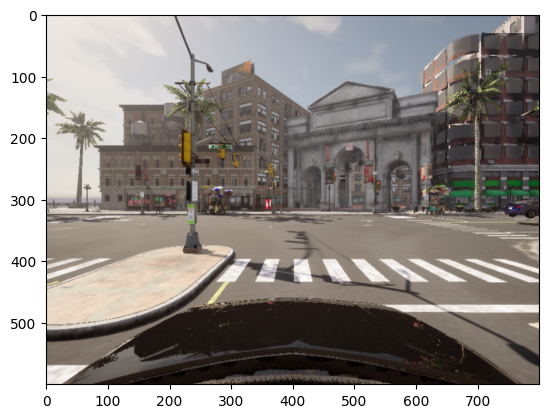

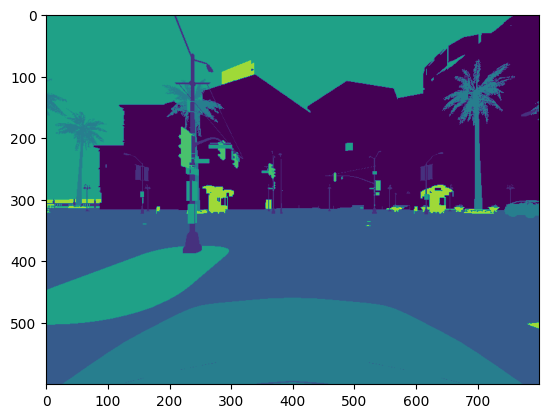

In [4]:
imgs, masks = load_dataset(datasetname)
print("Num images", len(imgs), ", Shapes:",imgs.shape, masks.shape)
print(imgs.min(), imgs.max(), masks.min(), masks.max())
plt.imshow(transform_toimage(imgs[0]))
plt.show()
plt.imshow(masks[0].squeeze())
plt.show()

In [5]:
#plt.hist(masks.view(-1),bins=100)

In [6]:
import torch.utils.data as tutils
from torch.utils.data.sampler import SubsetRandomSampler

# Split training and validation sets
def split_datasets(totaldata, valid_size=0.1, batch_size=batch_size):
    
    num_train = len(totaldata)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split_valid = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split_valid:], indices[:split_valid]

    # Define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Create loaders
    train_loader = tutils.DataLoader(totaldata, batch_size=batch_size, sampler=train_sampler, num_workers=12, drop_last=True) # batchsize=1 raises problems in DeepLabv3, avoid last batch with that size with drop_last=True
    valid_loader = tutils.DataLoader(totaldata, batch_size=batch_size, sampler=valid_sampler, num_workers=12, drop_last=True)

    return train_loader, valid_loader

totdataset = tutils.TensorDataset(imgs, masks)
train_loader, valid_loader = split_datasets(totdataset)

# Check shape
img, mask = next(iter(train_loader))
img.shape, mask.shape

(torch.Size([2, 3, 600, 800]), torch.Size([2, 1, 600, 800]))

In [7]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

def createDeepLabv3(outputchannels=1, nettype="resnet101"):

    if nettype=="resnet101":
        weightsdeeplab=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
        model = models.segmentation.deeplabv3_resnet101(weights=weightsdeeplab)
    elif nettype=="resnet50":
        weightsdeeplab=models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
        model = models.segmentation.deeplabv3_resnet50(weights=weightsdeeplab)
        
    #model.classifier = DeepLabHead(2048, outputchannels)
    model.classifier[4] = torch.nn.Conv2d(256, outputchannels, kernel_size=(1, 1), stride=(1, 1)) # Change final layer to outputchannels classes

    return model

In [8]:
SMOOTH = 1e-6

def iou(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    #outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    return iou

@torch.no_grad()
def get_mIoU(model, valid_loader):

    mIoU = torch.empty(0,device=device)
    for img, mask in valid_loader:
        img =img.to(device)
        mask = mask.to(device)
        out = model(img)['out']
        out = torch.argmax(out, dim=1)
        mask = mask.squeeze(1)
        mIoU = torch.cat([mIoU, iou(out.long(), mask.long()) ])
    return mIoU.mean()

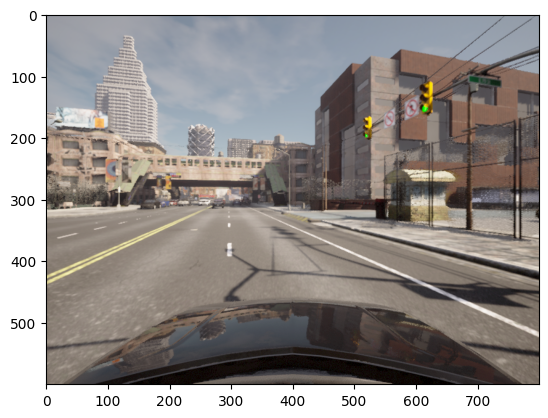

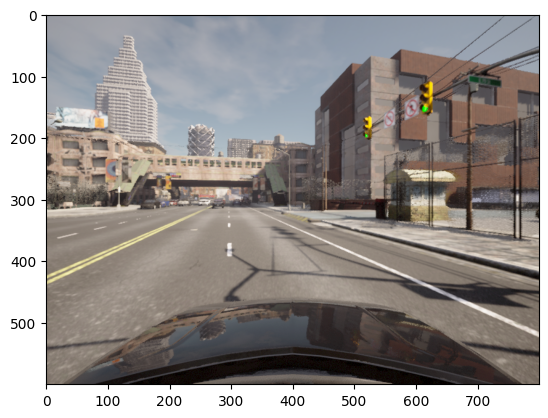

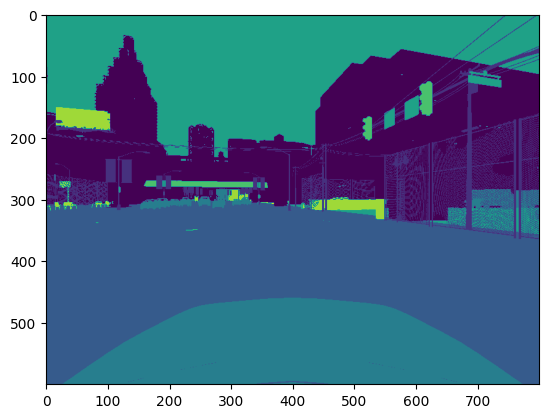

In [9]:
def dataaug(img, mask):
    state = torch.get_rng_state()
    img = augment_tf(img)
    torch.set_rng_state(state)
    mask = augment_tf(mask)
    return img, mask

img, mask = next(iter(valid_loader))

plt.imshow(transform_toimage(img[0]))
plt.show()
img, mask = dataaug(img, mask)
plt.imshow(transform_toimage(img[0]))
plt.show()
plt.imshow(mask[0].squeeze())
plt.show()

In [10]:
import copy
import csv
from tqdm import tqdm

def train(loader, criterion, optimizer, scheduler, phase="Train"):
    
    if phase=="Train":
        model.train()
    elif phase=="Valid":
        model.eval()
        
    epochloss = 0.
    
    for img, mask in tqdm(loader, total=len(loader), position=0, leave=True, desc=phase):
                
        img, mask = img.to(device), mask.to(device)
        if data_aug and phase=="Train":
            img, mask = dataaug(img, mask)

        out = model(img)["out"]
        loss = criterion(out, mask[:,0].long())
        epochloss += loss.item()

        if phase=="Train":
            loss.backward()
            optimizer.step()
            #scheduler.step()
            optimizer.zero_grad(set_to_none=True)
           
    return epochloss/len(loader.sampler)


def training_loop(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    
    time_init = time.time()
    best_loss = 1.e10
    best_mIoU = 0.
    model.to(device)
    optimizer.zero_grad(set_to_none=True)
    tbwriter = SummaryWriter(log_dir=logdir)
    
    #img_ref, mask_ref = next(iter(valid_loader))
    #img_ref, mask_ref = img_ref.to(device)[:1], mask_ref.to(device)[:1]
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        
        train_loss = train(train_loader, criterion, optimizer, scheduler, phase="Train")
        with torch.no_grad():
            valid_loss = train(valid_loader, criterion, optimizer, scheduler, phase="Valid")
        
        #tbwriter.add_images('Sample images', img_ref)
        #tbwriter.add_images('Sample outputs', torch.argmax(model(img_ref)["out"],dim=1,keepdim=True))
        
        mIoU = get_mIoU(model, valid_loader)
        tbwriter.add_scalar("mIoU", mIoU, epoch)
        
        tbwriter.add_scalar("Train loss", train_loss, epoch)
        tbwriter.add_scalar("Valid loss", valid_loss, epoch)
            
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), bestmodelname)
        if mIoU > best_mIoU:
            best_mIoU = mIoU
            torch.save(model.state_dict(), bestIoUmodelname)
            
        print("Epoch=", epoch, ", Train loss={:.2e}, Validation loss={:.2e}, mIoU={:.2f}".format(train_loss, valid_loss, mIoU) )
            
    time_elapsed = time.time() - time_init
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Lowest Validation Loss: {:4f}'.format(best_loss))

In [11]:
num_epochs = 10

model = createDeepLabv3(outputchannels=num_classes, nettype=nettype)

# Specify the loss function
#criterion = torch.nn.MSELoss(reduction='sum')
criterion = torch.nn.CrossEntropyLoss()
# Specify the optimizer with a lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Scheduler
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1.e-6, max_lr=1.e-3, cycle_momentum=False)
scheduler = None

# True for using data augmentation
data_aug = False

namerun = datasetname+"_"+nettype+"_dataaug_"+str(data_aug)+"_batch_"+str(batch_size)
tim = time.localtime()
strdate = "{:02d}-{:02d}_{:02d}:{:02d}".format(tim.tm_mday, tim.tm_mon, tim.tm_hour, tim.tm_min)
logdir = "runs/"+namerun+"_"+strdate
bestmodelname = "models/"+namerun+".pt"
bestIoUmodelname = "models/"+namerun+"_IoU.pt"

training_loop(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/10


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.21it/s]


Epoch= 1 , Train loss=1.78e-01, Validation loss=8.71e-02, mIoU=0.93
Epoch 2/10


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.80it/s]


Epoch= 2 , Train loss=6.74e-02, Validation loss=5.67e-02, mIoU=0.94
Epoch 3/10


Valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.82it/s]


Epoch= 3 , Train loss=5.76e-02, Validation loss=6.18e-02, mIoU=0.94
Epoch 4/10


Train:  88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 405/458 [03:05<00:24,  2.18it/s]


KeyboardInterrupt: 

In [12]:
def show_results(img, mask, out):
    
    fig, axs = plt.subplots(1, 3,figsize=(20,10))
    axs[0].imshow(img)
    axs[1].imshow(mask,vmin=0,vmax=num_classes)
    axs[2].imshow(out,vmin=0,vmax=num_classes)
    axs[0].set_title("Image")
    axs[1].set_title("Target")
    axs[2].set_title("Output")
    plt.show()

@torch.no_grad()
def infer(model, loader):

    model.to(device)
    model.eval()

    # Iterate over data.
    inputs, masks = next(iter(loader))
    inputs = inputs.to(device)
    masks = masks.to(device)
    outputs = model(inputs)['out']
    
    for ind in range(inputs.shape[0]):
        img = inputs[ind].cpu().detach()
        mask = masks[ind].cpu().detach().squeeze()
        out = outputs[ind]
        out = torch.argmax(out,0).cpu().detach()
        #out = torch.mean(out,0).cpu().detach()
        img = transform_toimage(img)
        show_results(img, mask, out)


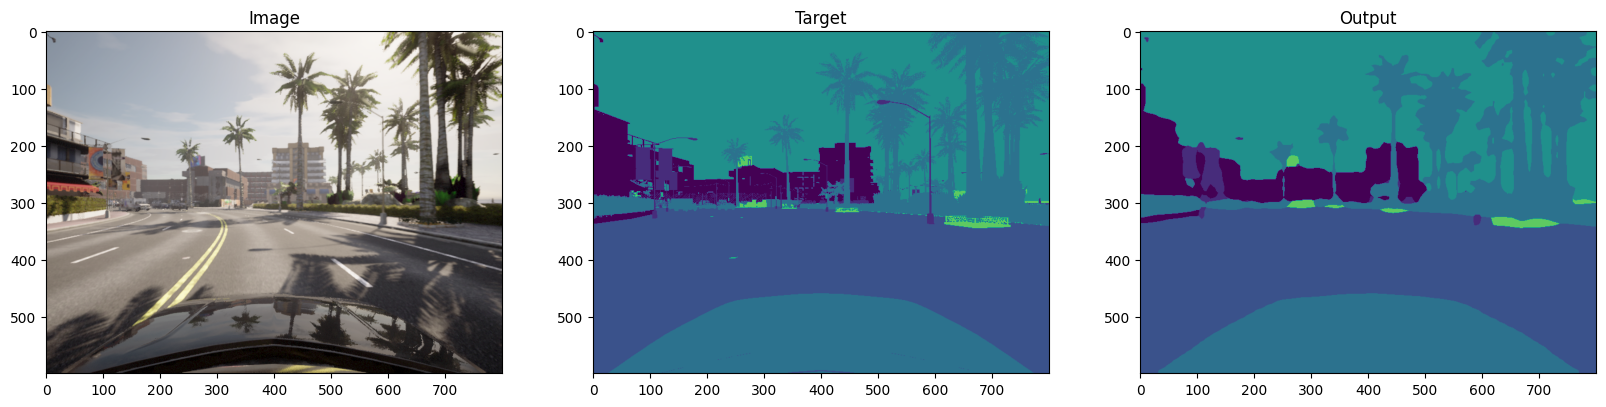

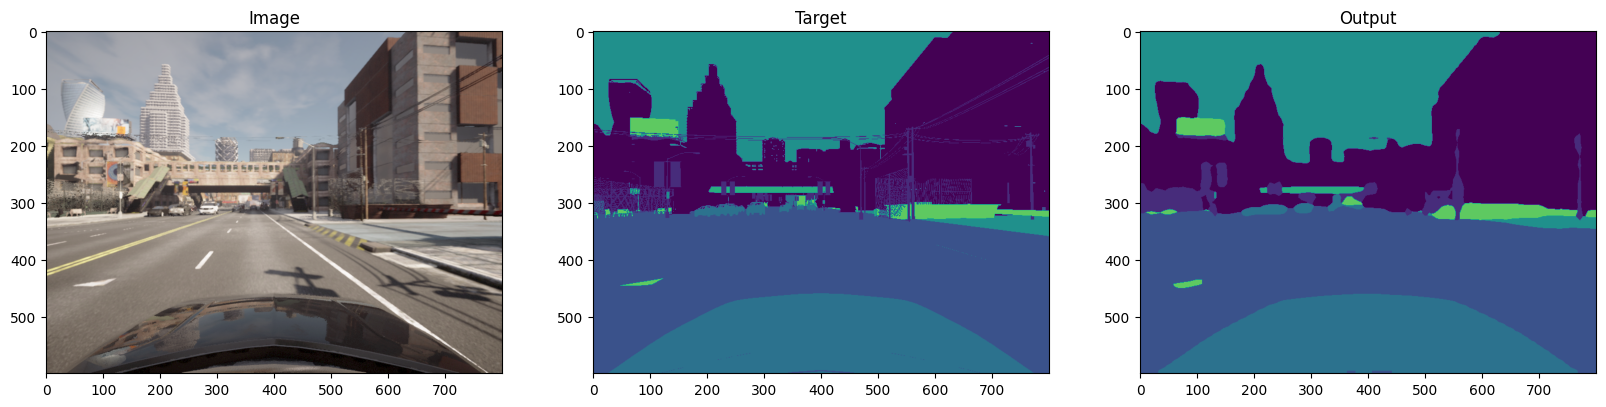

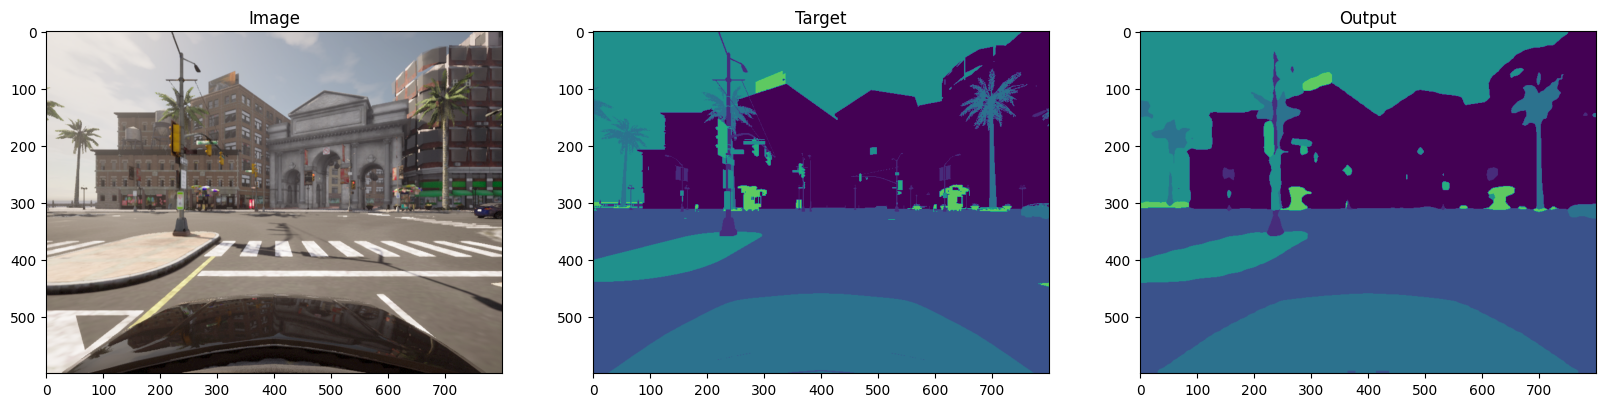

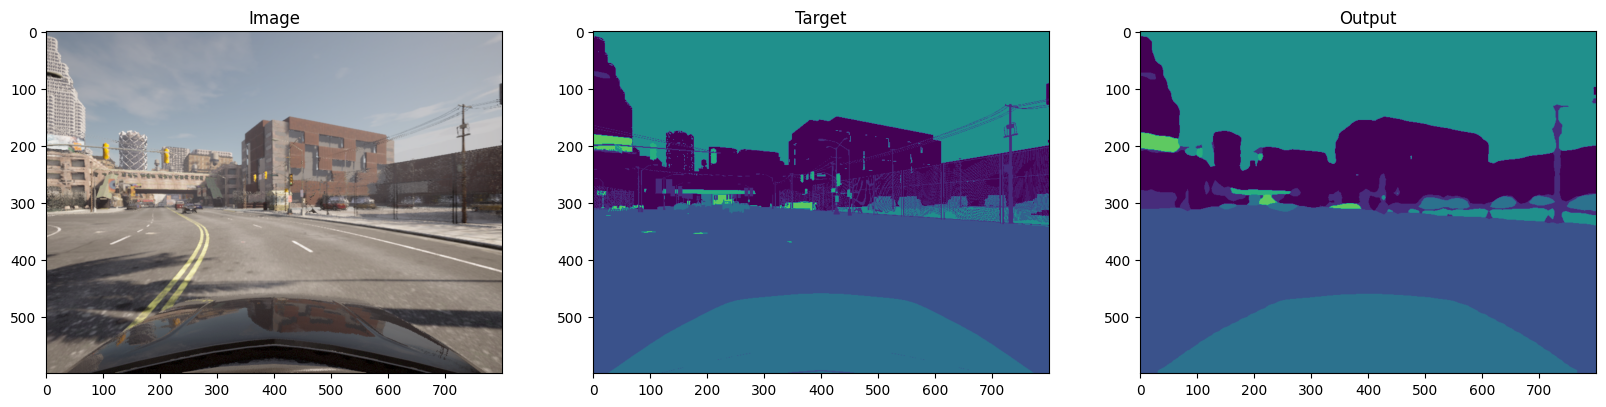

In [13]:
#state_dict = torch.load(bestmodelname, map_location=device)
state_dict = torch.load(bestIoUmodelname, map_location=device)
model.load_state_dict(state_dict)
infer(model, valid_loader)
infer(model, valid_loader)

In [14]:
print("mIoU: Train:", get_mIoU(model, train_loader), "Valid:", get_mIoU(model, valid_loader))

mIoU: Train: tensor(0.9458, device='cuda:0') Valid: tensor(0.9446, device='cuda:0')
